In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline

In [13]:
df = pd.read_csv('alumni', nrows=7000, names=['name', 'gender'])
df['name'] = df['name'].apply(lambda x: x.lower())
df['gender'] = df['gender'].apply(lambda x: 'male' if x else 'female')
df['length'] = df['name'].apply(len)
df['word_count'] = df['name'].apply(lambda x: len(x.split(' ')))
df['first_word'] = df['name'].apply(lambda x: x.split(' ')[0])
df['last_word'] = df['name'].apply(lambda x: x.split(' ')[-1])
df['first_char'] = df['name'].apply(lambda x: x[0])
df['last_char_first_word'] = df['first_word'].apply(lambda x: x[-1])
df['first_char_last_word'] = df['last_word'].apply(lambda x: x[0] if x else '')
df['last_char_last_word'] = df['last_word'].apply(lambda x: x[-1] if len(x) > 1 else '')
df.head()

,name,gender,length,word_count,first_word,last_word,first_char,last_char_first_word,first_char_last_word,last_char_last_word
0,edho prima arief,male,16,3,edho,arief,e,o,a,f
1,qonita hidayatullah,female,19,2,qonita,hidayatullah,q,a,h,h
2,raphon prima,male,12,2,raphon,prima,r,n,p,a
3,lina anugerah e w,female,17,4,lina,w,l,a,w,
4,nurhabibah,female,10,1,nurhabibah,nurhabibah,n,h,n,h


### Table of Contents

- [Experiments](#Experiments)
- [LSTM](#LSTM)

In [14]:
df.gender.value_counts()

male      4699
female    2301
Name: gender, dtype: int64

/home/engineering/miniconda2/envs/airy/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


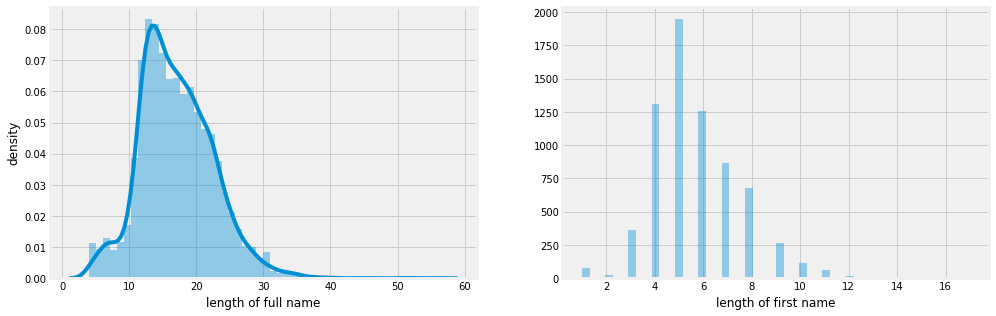

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.distplot(df.length, ax=ax[0])
sns.distplot(df.first_word.apply(len), kde=False, ax=ax[1])
ax[0].set_ylabel('density')
ax[0].set_xlabel('length of full name')
ax[1].set_xlabel('length of first name')
plt.show()

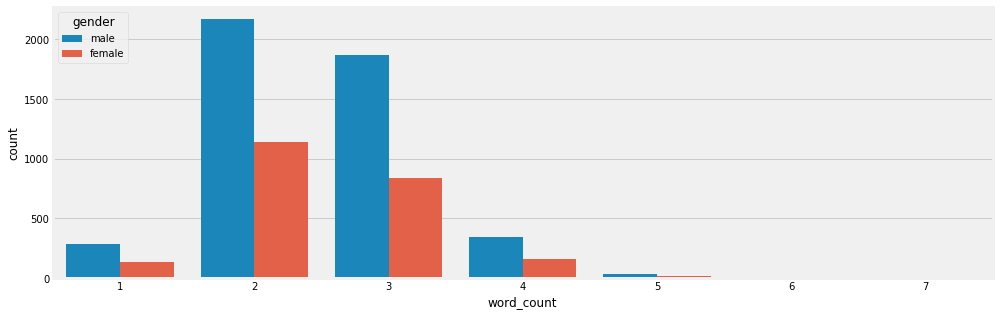

In [16]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.countplot(x='word_count', hue='gender', data=df, ax=ax)
plt.show()

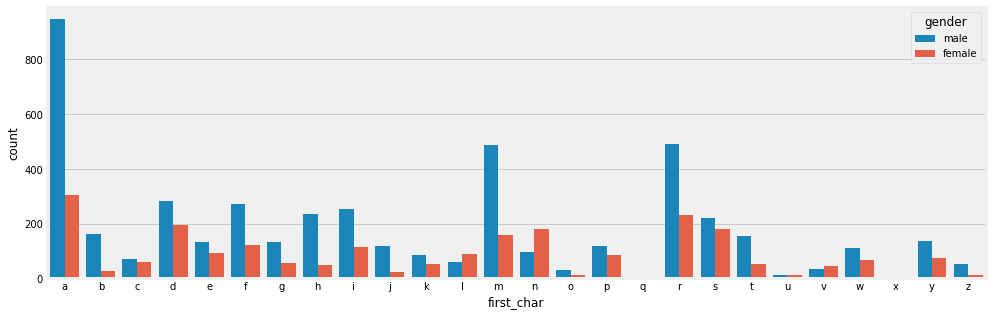

In [17]:
import string
fig, ax = plt.subplots(figsize=(15,5))
sns.countplot(x='first_char', hue='gender', data=df, order=string.ascii_lowercase, ax=ax)
plt.show()

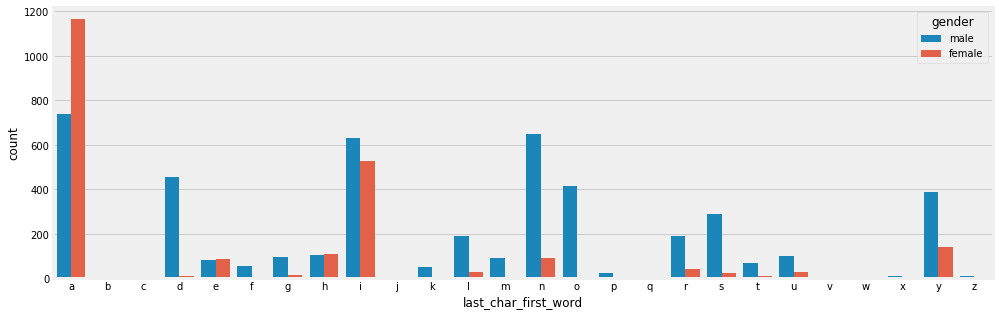

In [18]:
fig, ax = plt.subplots(figsize=(15,5))
sns.countplot(x='last_char_first_word', hue='gender', data=df, order=string.ascii_lowercase, ax=ax)
plt.show()

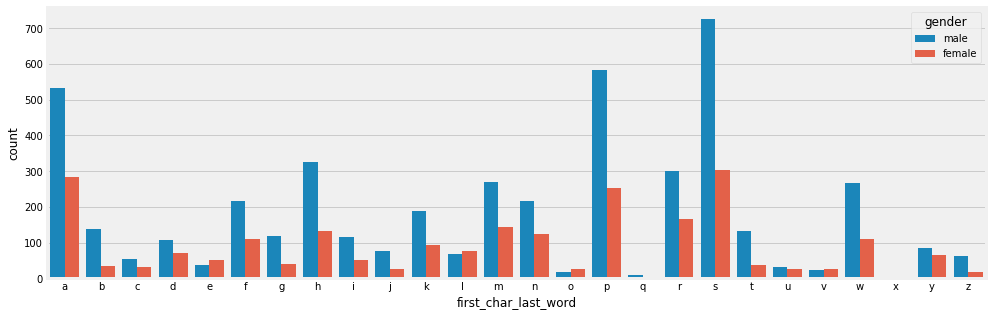

In [19]:
fig, ax = plt.subplots(figsize=(15,5))
sns.countplot(x='first_char_last_word', hue='gender', data=df, order=string.ascii_lowercase, ax=ax)
plt.show()

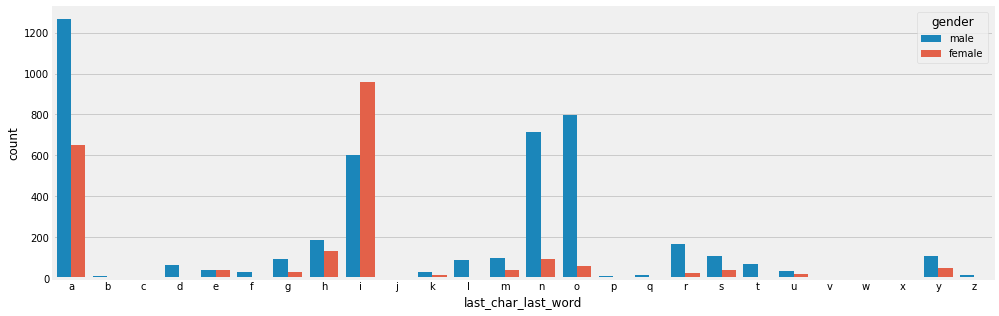

In [20]:
fig, ax = plt.subplots(figsize=(15,5))
sns.countplot(x='last_char_last_word', hue='gender', data=df, order=string.ascii_lowercase, ax=ax)
plt.show()

# Experiments

In [21]:
RAND_SEED_SPLIT = 1337

In [61]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier

In [54]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from umap import UMAP

In [121]:
X = df[['name']]
y = df['gender'].map({'male': 1, 'female': 0})

In [127]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RAND_SEED_SPLIT)

In [62]:
param_grid = {
    DummyClassifier: {},
    BernoulliNB: {},
    KNeighborsClassifier: {
        'n_neighbors': range(3,11)
    },
    LogisticRegression: {
        'penalty': ['l1','l2'],
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['liblinear']
    },
    XGBClassifier: {
        'max_depth': range(3,11),
        'min_child_weight': [0, 0.1, 1, 100, 1000],
        'gamma': [0, 0.1, 1, 100, 1000]
    }
}

In [63]:
clfs = [
    DummyClassifier,
    BernoulliNB,
    KNeighborsClassifier,
    LogisticRegression,
    XGBClassifier
]

In [72]:
pipe = make_pipeline(
    CountVectorizer(decode_error='ignore', token_pattern='\\w', ngram_range=(1, 3)),
    TruncatedSVD(100, random_state=42),
    UMAP(random_state=42)
)
X_map = pipe.fit_transform(X_train['name'])

In [137]:
import altair as alt

alt.Chart(pd.DataFrame({
    'x1': X_map[:,0],
    'x2': X_map[:,1],
    'label': y_train,
    'name': X_train['name']
}), width=1000, height=600).mark_point().encode(
    x='x1',
    y='x2',
    shape='label',
    color='label:N',
    tooltip='name'
).interactive()

<VegaLite 2 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


In [103]:
metrics = []

for C in clfs:
    clf = make_pipeline(
        CountVectorizer(decode_error='ignore', token_pattern='\\w', ngram_range=(1, 3)),
        TruncatedSVD(100, random_state=42),
        C()
    )

    clf.fit(X_train['name'], y_train)
    y_pred = clf.predict(X_test['name'])
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred)
    accuracy = balanced_accuracy_score(y_test, y_pred)
    metrics.append({'name': C.__name__, 'precision': precision[1], 'recall': recall[1], 'f1': f1[1], 'accuracy': accuracy})

pd.DataFrame(metrics)[['name','accuracy','f1','precision','recall']].set_index('name').style.format('{:.2%}')

/home/engineering/miniconda2/envs/airy/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


,accuracy,f1,precision,recall
name,,,,
DummyClassifier,49.12%,66.97%,67.91%,66.06%
BernoulliNB,73.22%,86.47%,81.40%,92.21%
KNeighborsClassifier,81.41%,89.05%,87.67%,90.47%
LogisticRegression,83.11%,90.07%,88.73%,91.45%
XGBClassifier,78.26%,88.23%,84.99%,91.72%


# LSTM

In [124]:
import string
import re

letters = string.ascii_lowercase + " "
n_letters = len(letters)

def clean_name(name):
    alphanum_pattern = re.compile('([^\s\w])+')
    return alphanum_pattern.sub('', name)

def nameToTensor(line):
    return [letters.find(letter) for letter in clean_name(line)]

In [125]:
df[df.name.apply(lambda x: nameToTensor(x).count(-1) > 0)].name

Series([], Name: name, dtype: object)

## Classifying by Name

In [215]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM, Bidirectional
from sklearn.metrics import classification_report, f1_score
import keras

RAND_SEED_SPLIT = 1337
np.random.seed(RAND_SEED_SPLIT)

maxlen = df.name.str.len().max()
max_features = n_letters

x_train = X_train.name.apply(nameToTensor).values
x_test = X_test.name.apply(nameToTensor).values

print('Pad sequences (samples x time)')
print(maxlen)
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Pad sequences (samples x time)
56
x_train shape: (4900, 56)
x_test shape: (2100, 56)


In [216]:
X_train.name.apply(lambda x: x.split(' ')[0]).apply(nameToTensor).values

array([list([5, 0, 17, 8, 3, 0, 13, 18, 24, 0, 7]),
       list([6, 8, 11, 0, 13, 6]), list([4, 17, 22, 8, 13]), ...,
       list([3, 0, 21, 8, 3]), list([12, 0, 20, 11, 0, 13, 0]),
       list([9, 7, 14, 13])], dtype=object)

In [217]:
def net():
    model = Sequential()
    model.add(Embedding(max_features, 128))
    model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))
    return model

Build model...
Train...
2100/2100 [==============================] - 1s 380us/step

Accuracy: 90.92%


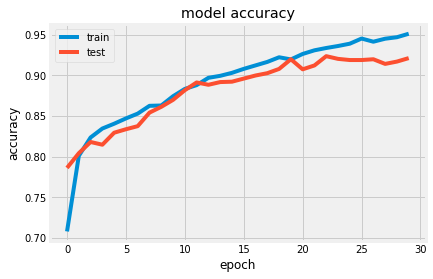

In [253]:
np.random.seed(42)

batch_size = 64

print('Build model...')
model = net()

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=30,
          verbose=0,
          validation_data=(x_test, y_test))
score, acc = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print()
# print('Test score:', score)
# print('Test accuracy:', acc)
y_pred = model.predict(x_test).reshape(-1)
print('Accuracy: {:.2%}'.format(balanced_accuracy_score(y_test, y_pred > .5)))

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [254]:
def predict(model, names):
    assert type(names) == list
    name_test = pd.Series(names)
    name_test = name_test.apply(nameToTensor).values
    name_test = sequence.pad_sequences(name_test, maxlen=maxlen)
    return model.predict(name_test)

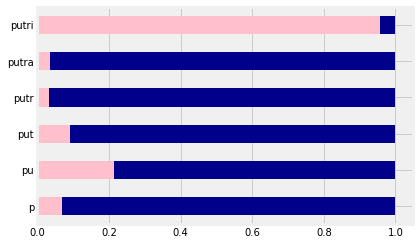

In [255]:
out = predict(model, ['p', 'pu', 'put', 'putr', 'putra', 'putri'])
fig, ax = plt.subplots()
pd.DataFrame(np.concatenate([1 - out, out], axis=1), columns=['female', 'male']).plot.barh(legend=False, color=['pink', 'darkblue'], stacked=True, ax=ax)
ax.set_yticklabels(['p', 'pu', 'put', 'putr', 'putra', 'putri'])
plt.savefig('putr.png', bbox_inches='tight')